In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, brier_score_loss, confusion_matrix
from sklearn.model_selection import GroupKFold  # we'll use groups to avoid leakage
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# ─── 1. Load data ───────────────────────────────────────────────
fold1_Pitch = "./data/Pitching.csv"
fold1_Master = "./data/Master.csv"
pitching = pd.read_csv(fold1_Pitch)
people   = pd.read_csv(fold1_Master)[["playerID", "birthYear"]]

# Merge to get age
pitching = pitching.merge(people, on="playerID", how="left")
pitching["age"] = pitching["yearID"] - pitching["birthYear"]

# Innings pitched (IP)
pitching["IP"] = pitching["IPouts"] / 3.0

# Filter modern era + reasonable sample
# change year or IP here....
df = pitching[(pitching["yearID"] >= 1871) & (pitching["IP"] >= 10)].copy()


In [4]:
df.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'birthYear', 'age', 'IP'],
      dtype='object')

In [5]:
# ─── 2. Define target: good season next year? ────────────────────
# Example: 1 = ERA ≤ 4.00 in next season (adjust threshold to taste)
df = df.sort_values(["playerID", "yearID"])

# Shift to get next year's ERA
df["ERA_next"] = df.groupby("playerID")["ERA"].shift(-1)
df["IP_next"]  = df.groupby("playerID")["IP"].shift(-1)

# Target: good performance next year (only consider if pitched enough)
# Try changing ERA_next or IP_next here
df["target"] = np.where(
    (df["ERA_next"] <= 4.00) & (df["IP_next"] >= 60),
    1, 0
)

# Drop rows without next season
df_model = df.dropna(subset=["target", "ERA_next", "age"]).copy()


In [6]:
df[["playerID","ERA","ERA_next","target","IP","IP_next"]].head(10)

,playerID,ERA,ERA_next,target,IP,IP_next
35564,aardsda01,6.75,4.08,0,10.666667,53.000000
36898,aardsda01,4.08,6.40,0,53.000000,32.333333
37598,aardsda01,6.40,5.55,0,32.333333,48.666667
38316,aardsda01,5.55,2.52,1,48.666667,71.333333
39016,aardsda01,2.52,3.44,0,71.333333,49.666667
39745,aardsda01,3.44,4.31,0,49.666667,39.666667
41858,aardsda01,4.31,4.70,0,39.666667,30.666667
43330,aardsda01,4.70,NaN,0,30.666667,NaN
21759,aasedo01,3.12,4.03,0,92.333333,178.666667
22173,aasedo01,4.03,4.81,0,178.666667,185.333333


In [7]:
# ─── 3. Feature engineering ──────────────────────────────────────
def add_lag_features(g):
    g = g.sort_values("yearID")
    for lag in [1,2,3]:
        g[f"ERA_lag{lag}"]   = g["ERA"].shift(lag)
        g[f"SO9_lag{lag}"]   = (g["SO"] / g["IP"] * 9).shift(lag)
        g[f"WHIP_lag{lag}"]  = ((g["H"] + g["BB"]) / g["IP"]).shift(lag)
        g[f"IP_lag{lag}"]    = g["IP"].shift(lag)
    
    # Rolling last 3 seasons (when available)
    g["ERA_last3"]  = g["ERA"].shift(1).rolling(3, min_periods=2).mean()
    g["SO9_last3"]  = (g["SO"]/g["IP"]*9).shift(1).rolling(3, min_periods=2).mean()
    g["age_trend"]  = g["age"] - g["age"].shift(1)
    
    return g

df_model = df_model.groupby("playerID", group_keys=False).apply(add_lag_features)

# Drop rows missing key lags
feature_cols = [
    "age", "ERA_lag1", "ERA_lag2", "ERA_last3",
    "SO9_lag1", "SO9_last3", "WHIP_lag1",
    "IP_lag1", "IP_lag2", "age_trend"
]
df_model = df_model.dropna(subset=feature_cols + ["target"])


In [8]:
df_model[['playerID', 'yearID','ERA','ERA_lag1','ERA_lag2','ERA_lag3']].head(10)

,playerID,yearID,ERA,ERA_lag1,ERA_lag2,ERA_lag3
37598,aardsda01,2007,6.40,4.08,6.75,NaN
38316,aardsda01,2008,5.55,6.40,4.08,6.75
39016,aardsda01,2009,2.52,5.55,6.40,4.08
39745,aardsda01,2010,3.44,2.52,5.55,6.40
41858,aardsda01,2013,4.31,3.44,2.52,5.55
22564,aasedo01,1979,4.81,4.03,3.12,NaN
22982,aasedo01,1980,4.06,4.81,4.03,3.12
23374,aasedo01,1981,2.34,4.06,4.81,4.03
23748,aasedo01,1982,3.46,2.34,4.06,4.81
24565,aasedo01,1984,1.62,3.46,2.34,4.06


In [9]:
df_model.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'birthYear', 'age', 'IP', 'ERA_next', 'IP_next', 'target', 'ERA_lag1',
       'SO9_lag1', 'WHIP_lag1', 'IP_lag1', 'ERA_lag2', 'SO9_lag2', 'WHIP_lag2',
       'IP_lag2', 'ERA_lag3', 'SO9_lag3', 'WHIP_lag3', 'IP_lag3', 'ERA_last3',
       'SO9_last3', 'age_trend'],
      dtype='object')

In [10]:
df_model["playerID"].nunique()

3451

In [11]:
df_model[['playerID', 'yearID','age', 'IP', 'ERA_next', 'IP_next', 'target', 'ERA_lag1',
       'SO9_lag1', 'WHIP_lag1', 'IP_lag1', 'ERA_lag2', 'SO9_lag2', 'WHIP_lag2',
       'IP_lag2', 'ERA_lag3', 'SO9_lag3', 'WHIP_lag3', 'IP_lag3', 'ERA_last3',
       'SO9_last3', 'age_trend']]

,playerID,yearID,age,IP,ERA_next,IP_next,target,ERA_lag1,SO9_lag1,WHIP_lag1,...,SO9_lag2,WHIP_lag2,IP_lag2,ERA_lag3,SO9_lag3,WHIP_lag3,IP_lag3,ERA_last3,SO9_last3,age_trend
37598,aardsda01,2007,26.0,32.333333,5.55,48.666667,0,4.08,8.320755,1.301887,...,4.218750,2.812500,10.666667,NaN,NaN,NaN,NaN,5.415000,6.269752,1.0
38316,aardsda01,2008,27.0,48.666667,2.52,71.333333,1,6.40,10.020619,1.731959,...,8.320755,1.301887,53.000000,6.75,4.218750,2.812500,10.666667,5.743333,7.520041,1.0
39016,aardsda01,2009,28.0,71.333333,3.44,49.666667,0,5.55,9.061644,1.726027,...,10.020619,1.731959,32.333333,4.08,8.320755,1.301887,53.000000,5.343333,9.134339,1.0
39745,aardsda01,2010,29.0,49.666667,4.31,39.666667,0,2.52,10.093458,1.163551,...,9.061644,1.726027,48.666667,6.40,10.020619,1.731959,32.333333,4.823333,9.725240,1.0
41858,aardsda01,2013,32.0,39.666667,4.70,30.666667,0,3.44,8.879195,1.167785,...,10.093458,1.163551,71.333333,5.55,9.061644,1.726027,48.666667,3.836667,9.344765,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14853,zuverge01,1955,31.0,86.333333,6.99,28.333333,0,3.59,3.103448,1.295567,...,4.973684,1.460526,25.333333,NaN,NaN,NaN,NaN,4.460000,4.038566,1.0
14854,zuverge01,1955,31.0,28.333333,4.16,97.333333,0,2.19,3.231660,1.123552,...,3.103448,1.295567,203.000000,5.33,4.973684,1.460526,25.333333,3.703333,3.769598,0.0
15124,zuverge01,1956,32.0,97.333333,2.48,112.666667,1,6.99,4.129412,1.835294,...,3.231660,1.123552,86.333333,3.59,3.103448,1.295567,203.000000,4.256667,3.488173,1.0
15392,zuverge01,1957,33.0,112.666667,3.39,69.000000,1,4.16,3.051370,1.500000,...,4.129412,1.835294,28.333333,2.19,3.231660,1.123552,86.333333,4.446667,3.470814,1.0


In [12]:
# ─── 4. Train / test split (time-aware) ──────────────────────────
train = df_model[df_model["yearID"] <= 2010]
test  = df_model[df_model["yearID"] >  2010]

X_train = train[feature_cols]
y_train = train["target"]

X_test  = test[feature_cols]
y_test  = test["target"]

print(f"Train seasons: {train['yearID'].min()}-{train['yearID'].max()}")
print(f"Test  seasons: {test['yearID'].min()}-{test['yearID'].max()}")
print(f"Class balance: {y_train.mean():.3f} (fraction of good seasons)")

Train seasons: 1872-2010
Test  seasons: 2011-2015
Class balance: 0.412 (fraction of good seasons)


In [13]:
X_train.columns

Index(['age', 'ERA_lag1', 'ERA_lag2', 'ERA_last3', 'SO9_lag1', 'SO9_last3',
       'WHIP_lag1', 'IP_lag1', 'IP_lag2', 'age_trend'],
      dtype='object')

In [14]:
# ─── 5. Scale & model ────────────────────────────────────────────
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

model = LogisticRegression(
    penalty="l2",
    C=0.5,                  # moderate regularization
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

model.fit(X_train_sc, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
# ─── 6. Evaluate ─────────────────────────────────────────────────
proba_test = model.predict_proba(X_test_sc)[:, 1]
pred_test  = model.predict(X_test_sc)

print("\n=== Test Performance ===")
print(f"ROC AUC      : {roc_auc_score(y_test, proba_test):.4f}")
print(f"Brier score  : {brier_score_loss(y_test, proba_test):.4f}")
print(f"Accuracy     : {(pred_test == y_test).mean():.4f}")
print("\nClassification report:")
print(classification_report(y_test, pred_test, digits=3))

# Coefficients
coefs = pd.Series(model.coef_[0], index=feature_cols).sort_values(ascending=False)
print("\nFeature coefficients:")
print(coefs.round(3))

# Example interpretation: negative coef on ERA_last3 → lower recent ERA → higher prob of good next season


=== Test Performance ===
ROC AUC      : 0.6217
Brier score  : 0.2302
Accuracy     : 0.6166

Classification report:
              precision    recall  f1-score   support

           0      0.717     0.684     0.700       862
           1      0.449     0.488     0.468       455

    accuracy                          0.617      1317
   macro avg      0.583     0.586     0.584      1317
weighted avg      0.624     0.617     0.620      1317


Feature coefficients:
SO9_lag1     0.318
IP_lag1      0.267
IP_lag2      0.142
age_trend    0.056
ERA_lag2    -0.047
WHIP_lag1   -0.083
ERA_lag1    -0.090
age         -0.201
ERA_last3   -0.247
SO9_last3   -0.292
dtype: float64


In [16]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

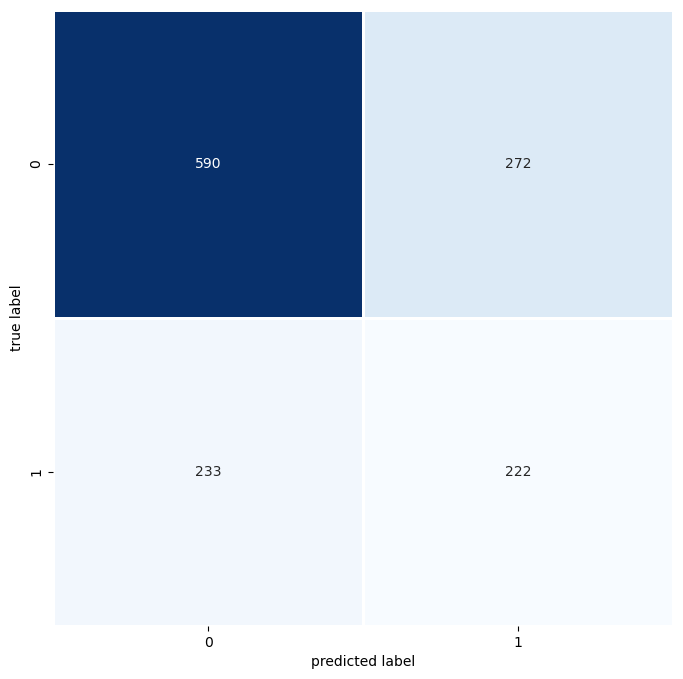

In [17]:
plot_confusion_matrix(y_test, pred_test)

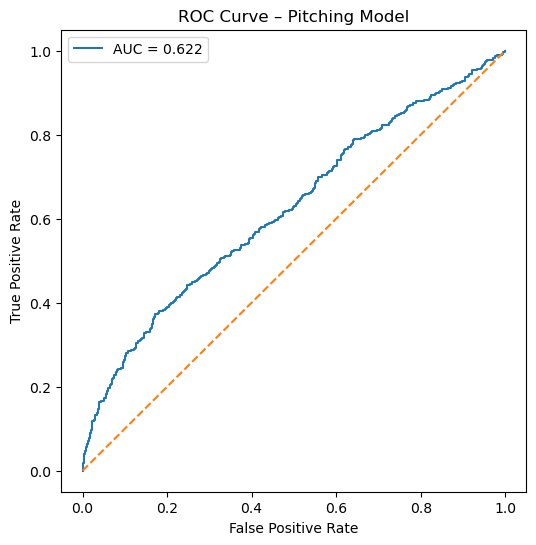

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Pitching Model")
plt.legend()
plt.show()

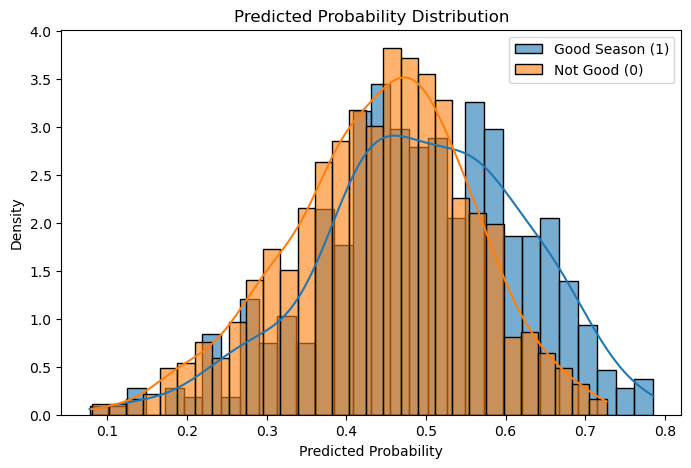

In [19]:
plt.figure(figsize=(8,5))

sns.histplot(proba_test[y_test==1], bins=30, kde=True, stat="density", label="Good Season (1)", alpha=0.6)
sns.histplot(proba_test[y_test==0], bins=30, kde=True, stat="density", label="Not Good (0)", alpha=0.6)

plt.xlabel("Predicted Probability")
plt.title("Predicted Probability Distribution")
plt.legend()
plt.show()

#### Feature Importance (Logistic Coefficients)

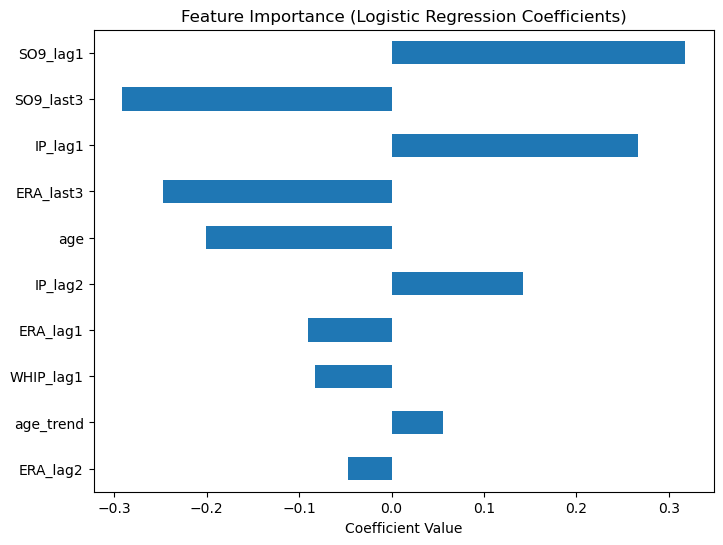

In [20]:
coefs = pd.Series(model.coef_[0], index=X_train.columns)
coefs = coefs.sort_values(key=abs, ascending=True)

plt.figure(figsize=(8,6))
coefs.plot(kind="barh")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()

#### Calibration Plot (Probability Reliability)

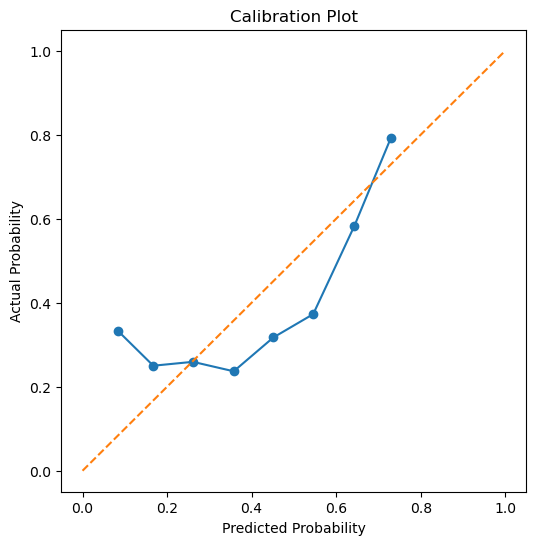

In [21]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.title("Calibration Plot")
plt.show()

Age vs Predicted Probability

In [22]:
test = test.copy()
test["pred_prob"] = proba_test

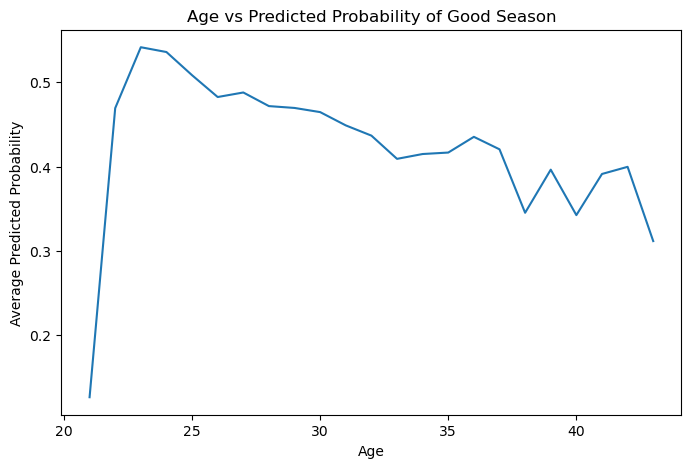

In [23]:
age_group = test.groupby("age")["pred_prob"].mean()

plt.figure(figsize=(8,5))
age_group.plot()
plt.xlabel("Age")
plt.ylabel("Average Predicted Probability")
plt.title("Age vs Predicted Probability of Good Season")
plt.show()

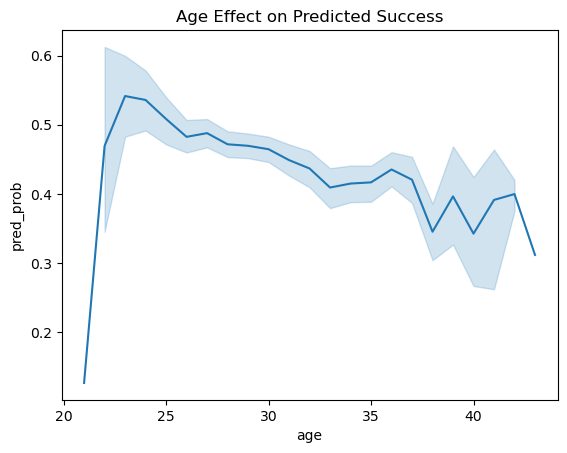

In [25]:
# Optional Smoothing: 
sns.lineplot(data=test, x="age", y="pred_prob")
plt.title("Age Effect on Predicted Success")
plt.show()

#### Predicted vs Actual Scatter (Player-Level View)

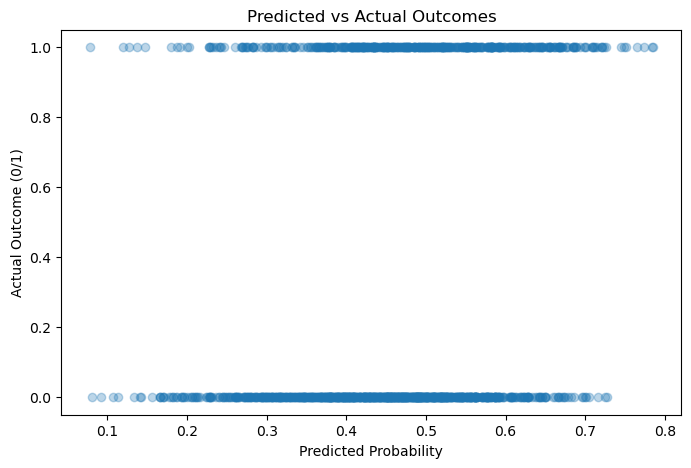

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(test["pred_prob"], test["target"], alpha=0.3)
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Outcome (0/1)")
plt.title("Predicted vs Actual Outcomes")
plt.show()

#### Confusion Matrix Heatmap

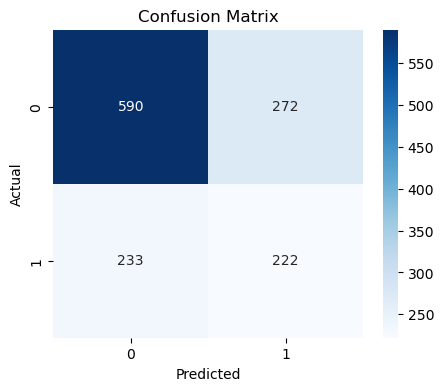

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()